In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from lecilab_behavior_analysis.utils import load_example_data
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
mouse = "mouse1"
df = load_example_data(mouse)

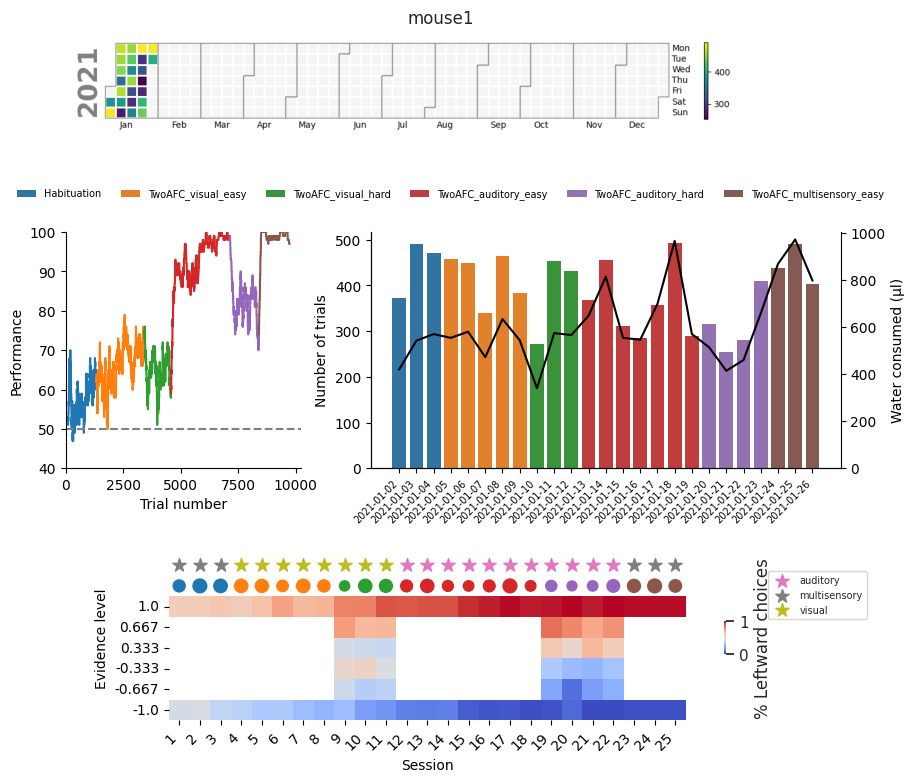

In [3]:
from lecilab_behavior_analysis.figure_maker import subject_progress_figure
fig = subject_progress_figure(df, mouse, perf_window=100)


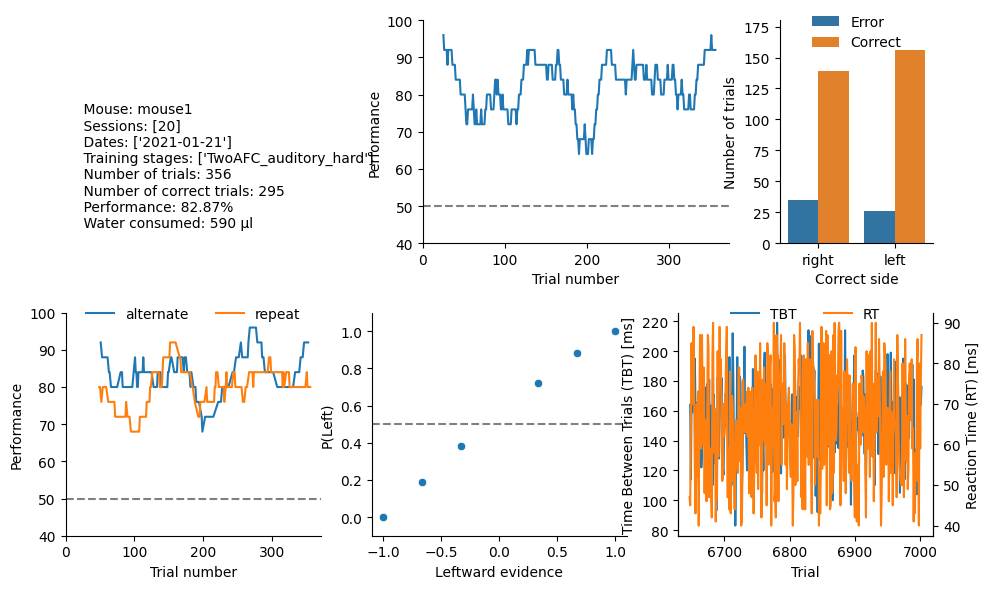

In [101]:
from lecilab_behavior_analysis.figure_maker import session_summary_figure
# select the session you want to plot
session = 20
sdf = df[df["session"] == session]
fig = session_summary_figure(sdf, mouse, perf_window=25)

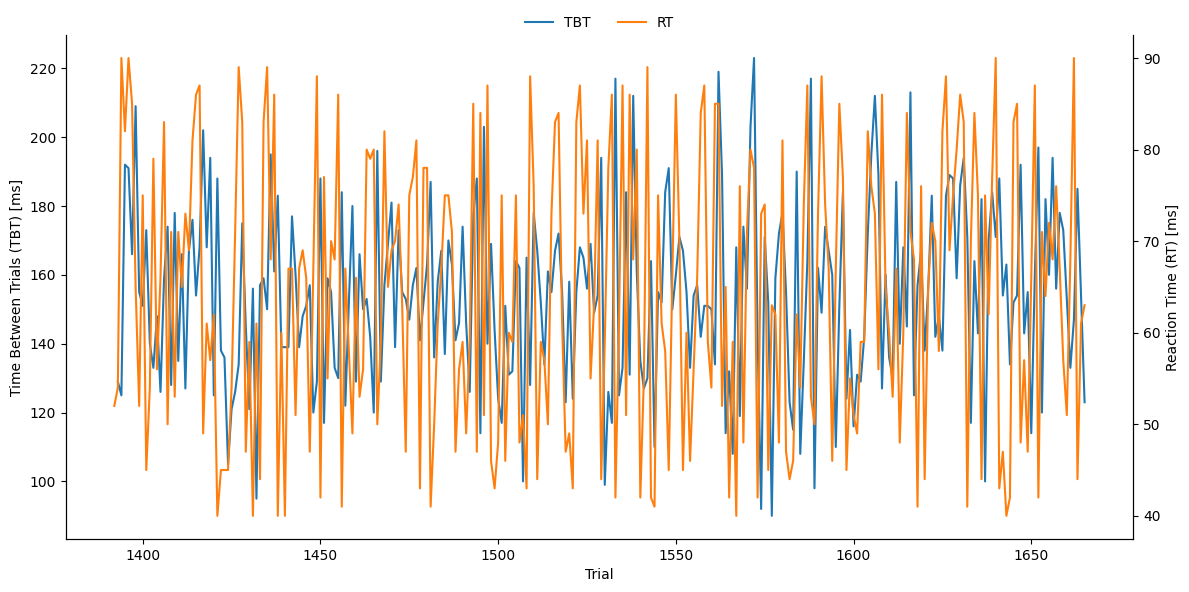

In [100]:
from lecilab_behavior_analysis.plots import plot_time_between_trials_and_reaction_time
from lecilab_behavior_analysis.df_transforms import calculate_times
session = 5
df = calculate_times(df)
sdf = df[df["session"] == session].copy()
fig = plot_time_between_trials_and_reaction_time(sdf)
